In [ ]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.transformations import unwrap
import numpy as np
import matplotlib.pyplot as plt

topology = "dry_1kx5_DNA.prmtop"
traj = "DNA_trace_all.dcd"


In [ ]:
u = mda.Universe(topology, traj)

# Unwrap PBC (important for large systems)
u.trajectory.add_transformations(unwrap(u.atoms))

# Use first frame as reference
u.trajectory[0]
align_sel = "nucleic and name P"   
u_init = u.select_atoms(align_sel).copy()
# print(u_init)

<AtomGroup [<Atom 31: P of type P of resname DT, resid 2 and segid SYSTEM>, <Atom 63: P of type P of resname DC, resid 3 and segid SYSTEM>, <Atom 93: P of type P of resname DA, resid 4 and segid SYSTEM>, ..., <Atom 9249: P of type P of resname DG, resid 292 and segid SYSTEM>, <Atom 9282: P of type P of resname DA, resid 293 and segid SYSTEM>, <Atom 9314: P of type P of resname DT3, resid 294 and segid SYSTEM>]>


In [24]:
def basepair_cog(u, res1_start, res1_end, res2_start, res2_end):
    basepair_cogs = []
    n_bp = res1_end - res1_start + 1
    for i in range(n_bp):
        resid1 = res1_start + i
        resid2 = res2_end - i
        sel1 = u.select_atoms(f"resid {resid1} and nucleic")
        sel2 = u.select_atoms(f"resid {resid2} and nucleic")
        combined_atoms = sel1 + sel2
        cog = combined_atoms.center_of_geometry()
        basepair_cogs.append(cog[:2])  # X, Y only
    return np.array(basepair_cogs)


# ---- Reference structure ----
cog_init = basepair_cog(u_init, 1, 147, 148, 294)
mean_xy = np.nanmean(cog_init, axis=0)
cog_init_centered = cog_init - mean_xy

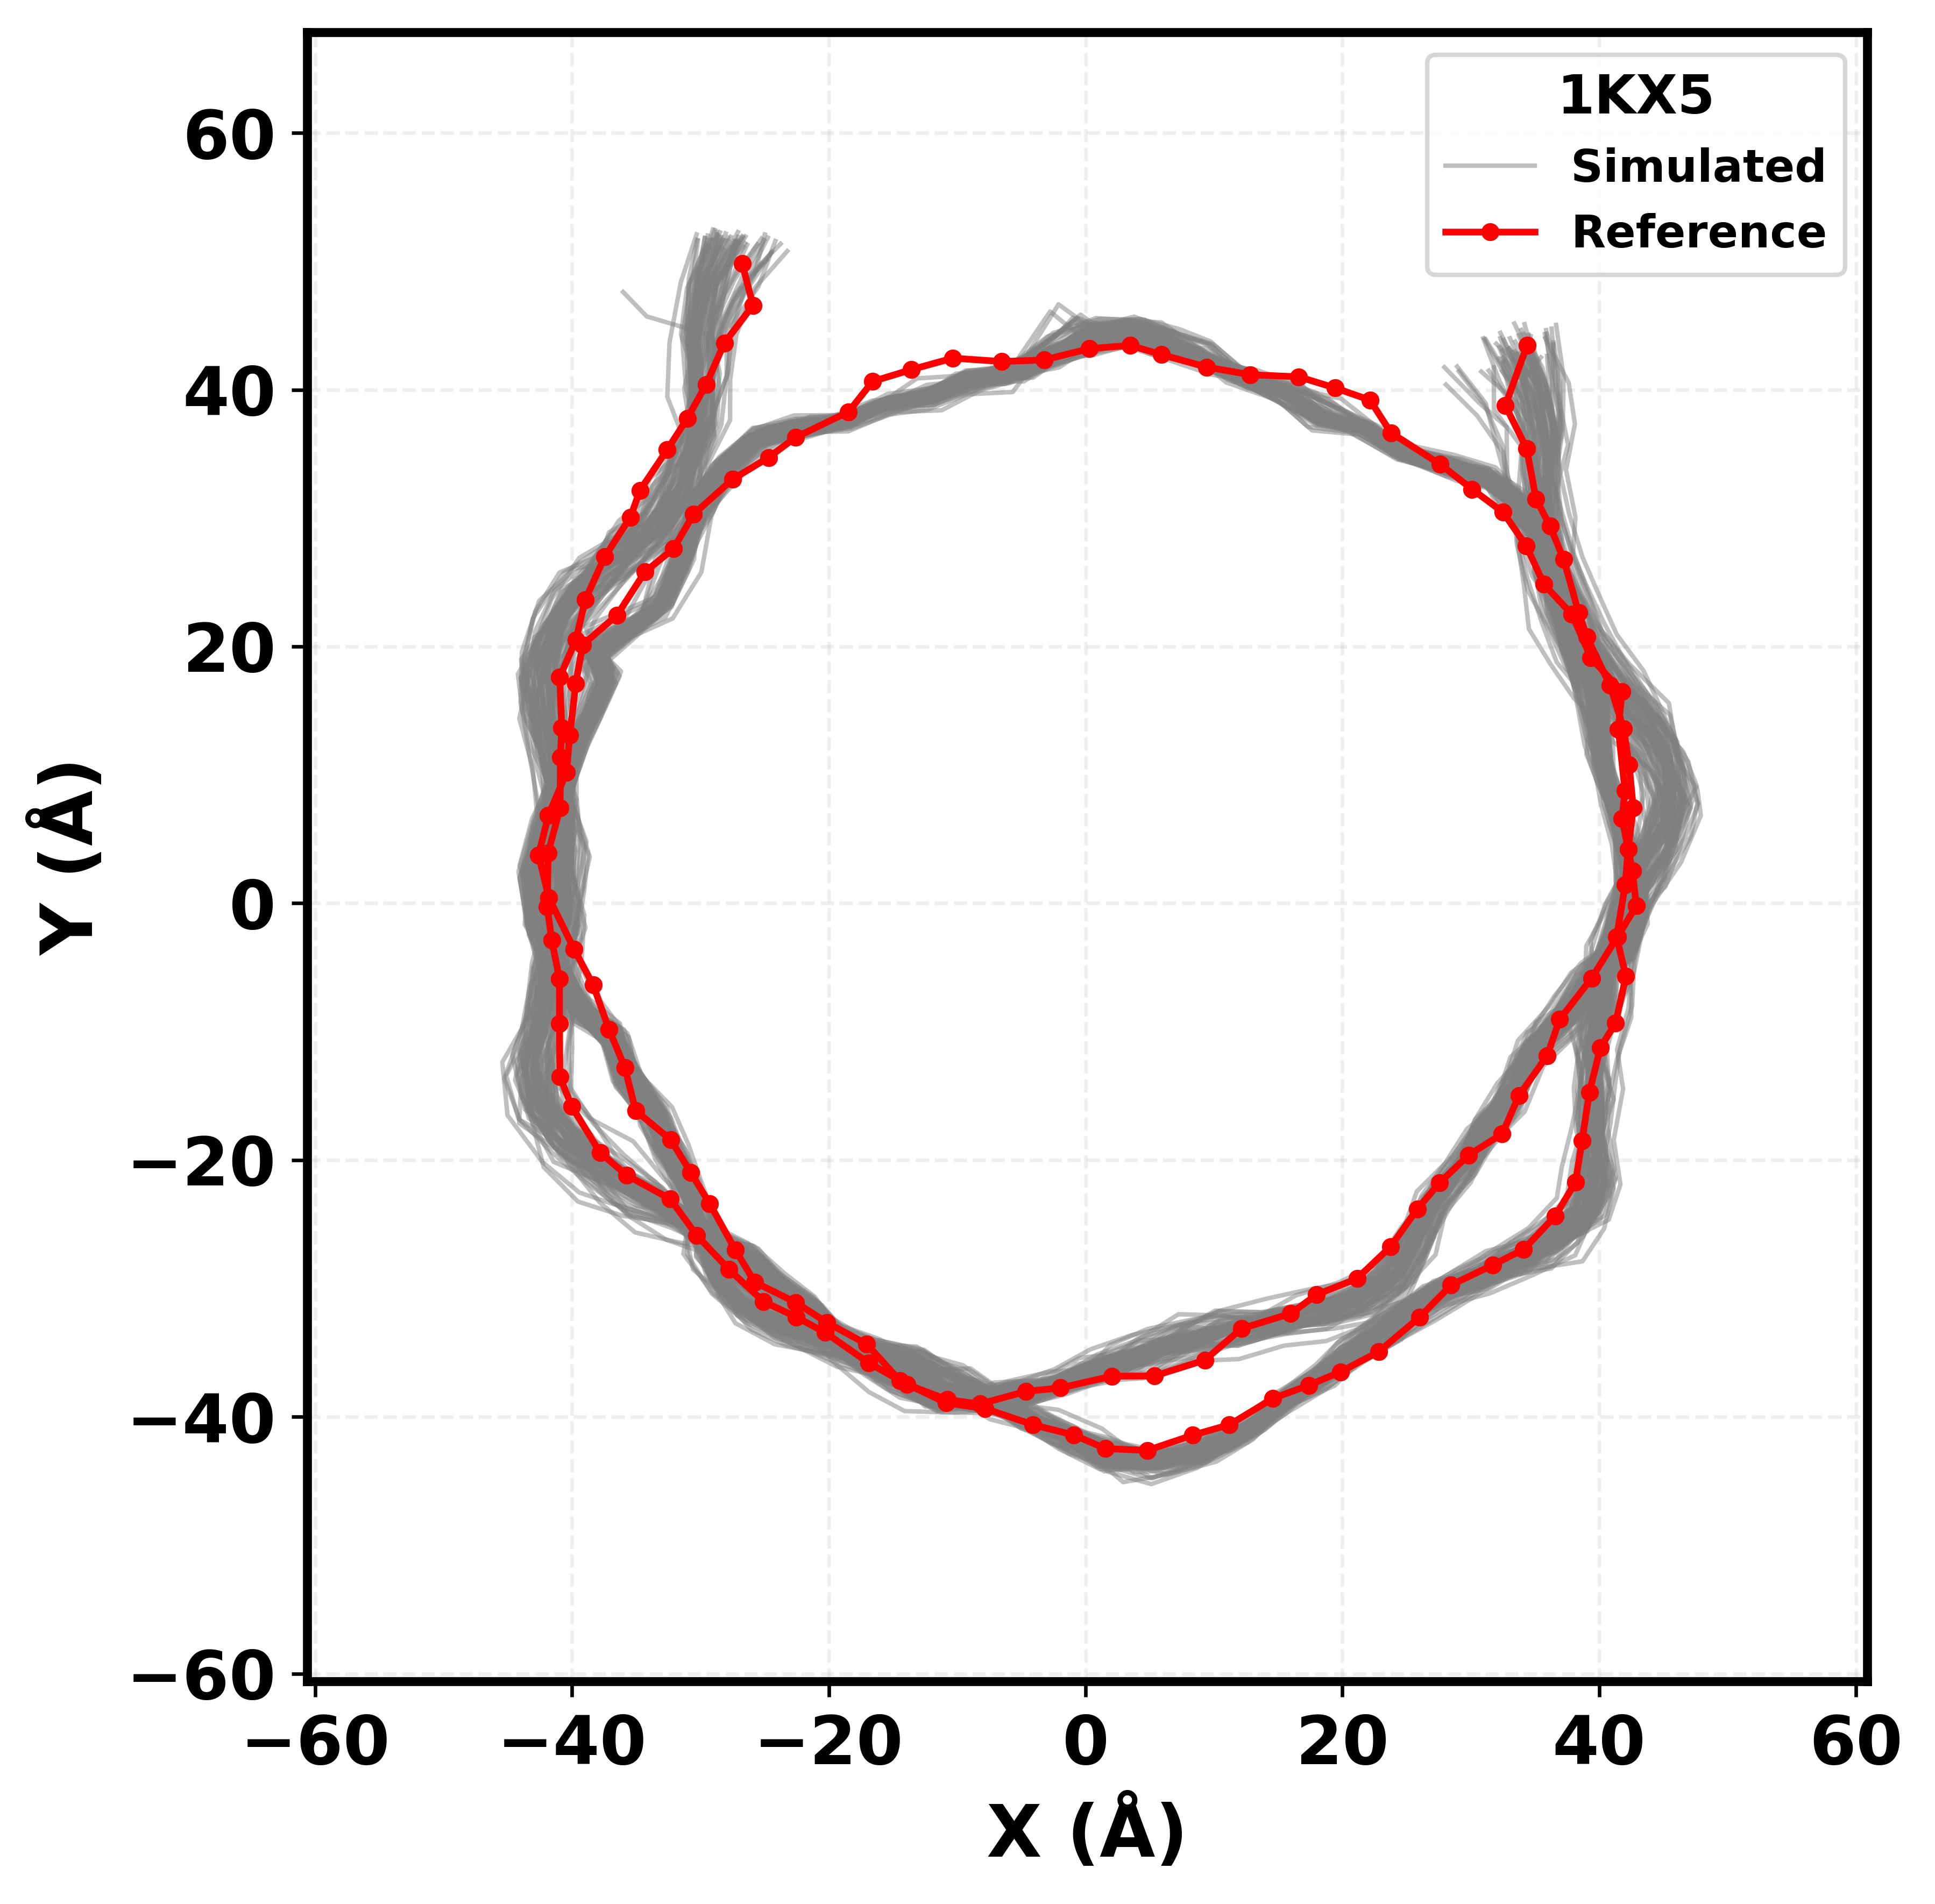

In [ ]:
from matplotlib.font_manager import FontProperties

# ---- Plot setup ----
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

title_fp = FontProperties(weight='bold', size=12)
label_fp = FontProperties(weight='bold', size=10)

# Plot every 5th frame
for i, ts in enumerate(u.trajectory):
    if i % 10 == 0:
        cog_frame = basepair_cog(u, 1, 147, 148, 294)
        cog_frame_centered = cog_frame - mean_xy
        label = 'Simulated' if i == 0 else '_nolegend_'
        # label = 'MD' if idx == 0 and i == 0 else '_nolegend_'
        ax.plot(cog_frame_centered[:, 0], cog_frame_centered[:, 1], color='grey', alpha=0.5, linewidth=1, label=label)


# ---- Plot initial structure ----
ax.plot(cog_init_centered[:, 0], cog_init_centered[:, 1], color='red', linewidth=1.5, markersize=3,  marker='o', label='Reference')

# ---- Formatting ----
ax.set_aspect('equal')

plt.xlabel('X (Å)', color='black', fontsize=16, fontweight='bold')
plt.ylabel('Y (Å)', color='black', fontsize=16, fontweight='bold')

x_margin = 18
y_margin = 18
plt.xlim(np.min(cog_init_centered[:, 0]) - x_margin, np.max(cog_init_centered[:, 0]) + x_margin)
plt.ylim(np.min(cog_init_centered[:, 1]) - y_margin, np.max(cog_init_centered[:, 1]) + y_margin)

plt.xticks(color='black', fontsize=15, fontweight='bold')
plt.yticks(color='black', fontsize=15, fontweight='bold')

# Border styling
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(title="1KX5", prop=label_fp, title_fontproperties=title_fp)

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()